# Setup 

<div style="background-color: #ffebee; border: 2px solid #d32f2f; padding: 10px; border-radius: 5px; color: #b71c1c;">
        <b>Caution:</b> The setup code below only needs to be run once per assignment. If you've already executed it, you can safely ignore this section and proceed to the <a href="#assignment-content" style="color: #d32f2f; text-decoration: underline;">Assignment Content</a>.
    </div>

This will run through setup of all necessary dependencies to complete the assignment.

## Install required tools

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    # fixing error like "No module named 'imp'"
    !sed -i -e 's/from imp import reload/from importlib import reload/' /usr/local/lib/python3.12/dist-packages/IPython/extensions/autoreload.py
else:
  import os
  # add local dependencies to PATH (for uv installation)
  os.environ['PATH'] = '/usr/local/bin:$HOME/.local/bin:' + os.environ['PATH']
  # add conda dependencies to PATH (for conda installation)
  os.environ['PATH'] = '/opt/anaconda3:~/anaconda3:~:~/miniconda3:/opt/miniconda3:' + os.environ['PATH']

## Install datasets

The code snippets below will mount your Google Drive folder (if in a Colab environment) and proceed to install the relevant datasets needed to complete the assignment.

In [2]:
if IN_COLAB:
    # TODO: For colab, Enter the foldername in your Google Drive
    # to the root of the assignment folder, where this notebook exists
    # e.g. 'XCS231N/XCS231N-A?/src/submission' # you need to update "A?" with the homework number
    FOLDERNAME = 'path to your submission folder, see the above description'
    WORK_DIR = '/content/drive/MyDrive/{}'.format(FOLDERNAME)
    # This mounts your Google Drive to the Colab VM.
    from google.colab import drive
    drive.mount('/content/drive')

    assert FOLDERNAME is not None, "[!] Enter the foldername."

    # Now that we've mounted your Drive, this ensures that
    # the Python interpreter of the Colab VM can load
    # python files from within it.
    import sys
    sys.path.append(WORK_DIR)
else:
    # on local or azure, FOLDERNAME is set automatically
    FOLDERNAME=os.getcwd()
    WORK_DIR = FOLDERNAME

print(f"FOLDERNAME: ", FOLDERNAME)
print(f"WORK_DIR: ", WORK_DIR)

FOLDERNAME:  d:\course\XCS231N-Course\XCS231N-A1\src\submission
WORK_DIR:  d:\course\XCS231N-Course\XCS231N-A1\src\submission


In [3]:
print("Getting dataset: START")
%cd $WORK_DIR/xcs231n/datasets
!bash get_datasets.sh
%cd $WORK_DIR
print("Getting dataset: DONE")

Getting dataset: START
d:\course\XCS231N-Course\XCS231N-A1\src\submission\xcs231n\datasets
d:\course\XCS231N-Course\XCS231N-A1\src\submission
Getting dataset: DONE


# Package Manager Setup

Below you have the option to run through the installation of `uv` package manager. Optionally, you can still work with `conda`.

## `uv` (preferred)

In [ ]:
if not IN_COLAB:
  %cd $WORK_DIR/../..
  !source install.sh -r
  !source .venv/bin/activate

## `conda` (legacy)

In [4]:
# uncomment to use conda
# if IN_COLAB:
#     !pip install -q condacolab
#     import condacolab
#     condacolab.install()
#     %cd $WORK_DIR/src
#     !conda env create -f environment.yml
#     !exec bash
# else:
#     %cd $WORK_DIR/src
#     !conda env create -f environment.yml

---

<a id="assignment-content"></a>

# Assignment Content

# Image features exercise

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [6]:
import random
import numpy as np
from xcs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [7]:
from xcs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'xcs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [8]:
from xcs231n.features import *

# num_color_bins = 10 # Number of bins in the color histogram
num_color_bins = 25 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train Softmax classifier on features
Using the Softmax code developed earlier in the assignment, train Softmax classifiers on top of the features extracted above; this should achieve better results than training them directly on top of raw pixels.

In [13]:
# Use the validation set to tune the learning rate and regularization strength

from xcs231n.classifiers.linear_classifier import Softmax

learning_rates = [1e-7, 1e-6]
regularization_strengths = [5e5, 5e6]

# ### START CODE HERE ###
learning_rates = [6e-7, 5e-7, 4e-7, 3e-7, 1e-6, 5e-6]
regularization_strengths = [1e3, 1e4, 1e5, 5e5, 1e6]
# ### END CODE HERE ###

results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the Softmax; save#
# the best trained classifer in best_softmax. If you carefully tune the model, #
# you should be able to get accuracy of above 0.42 on the validation set.      #
################################################################################
# ### START CODE HERE ###
for lr in learning_rates:
    for reg in regularization_strengths:
        model = Softmax()
        model.train(X_train_feats, y_train, learning_rate=lr, reg=reg,
                    num_iters=1500, batch_size=200, verbose=False)
        
        y_train_pred = model.predict(X_train_feats)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = model.predict(X_val_feats)
        val_accuracy = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (train_accuracy, val_accuracy)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = model
# ### END CODE HERE ###

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved: %f' % best_val)

d:\course\XCS231N-Course\XCS231N-A1\src\submission\xcs231n\classifiers\softmax.py:95: RuntimeWarning: divide by zero encountered in log
  correct_logprobs = -np.log(probs[np.arange(num_train), y])
d:\course\XCS231N-Course\XCS231N-A1\src\submission\xcs231n\classifiers\softmax.py:97: RuntimeWarning: overflow encountered in scalar multiply
  loss += reg * np.sum(W * W)
c:\Users\klppd\.conda\envs\XCS231N_CUDA\Lib\site-packages\numpy\_core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
d:\course\XCS231N-Course\XCS231N-A1\src\submission\xcs231n\classifiers\softmax.py:97: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)
d:\course\XCS231N-Course\XCS231N-A1\src\submission\xcs231n\classifiers\softmax.py:112: RuntimeWarning: overflow encountered in multiply
  dW = dW / num_train + 2 * reg * W
d:\course\XCS231N-Course\XCS231N-A1\src\submission\xcs231n\classifiers\softmax.py:87: RuntimeWarnin

lr 3.000000e-07 reg 1.000000e+03 train accuracy: 0.097776 val accuracy: 0.104000
lr 3.000000e-07 reg 1.000000e+04 train accuracy: 0.419020 val accuracy: 0.413000
lr 3.000000e-07 reg 1.000000e+05 train accuracy: 0.423000 val accuracy: 0.434000
lr 3.000000e-07 reg 5.000000e+05 train accuracy: 0.402796 val accuracy: 0.413000
lr 3.000000e-07 reg 1.000000e+06 train accuracy: 0.382082 val accuracy: 0.358000
lr 4.000000e-07 reg 1.000000e+03 train accuracy: 0.130694 val accuracy: 0.133000
lr 4.000000e-07 reg 1.000000e+04 train accuracy: 0.426816 val accuracy: 0.435000
lr 4.000000e-07 reg 1.000000e+05 train accuracy: 0.417102 val accuracy: 0.408000
lr 4.000000e-07 reg 5.000000e+05 train accuracy: 0.392429 val accuracy: 0.396000
lr 4.000000e-07 reg 1.000000e+06 train accuracy: 0.350041 val accuracy: 0.330000
lr 5.000000e-07 reg 1.000000e+03 train accuracy: 0.117878 val accuracy: 0.115000
lr 5.000000e-07 reg 1.000000e+04 train accuracy: 0.424000 val accuracy: 0.425000
lr 5.000000e-07 reg 1.000000

In [14]:
# Evaluate your trained Softmax on the test set: you should be able to get at least 0.42
y_test_pred = best_softmax.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.429


In [15]:
# Save best softmax model
best_softmax.save("best_softmax_features.npy")

best_softmax_features.npy saved.


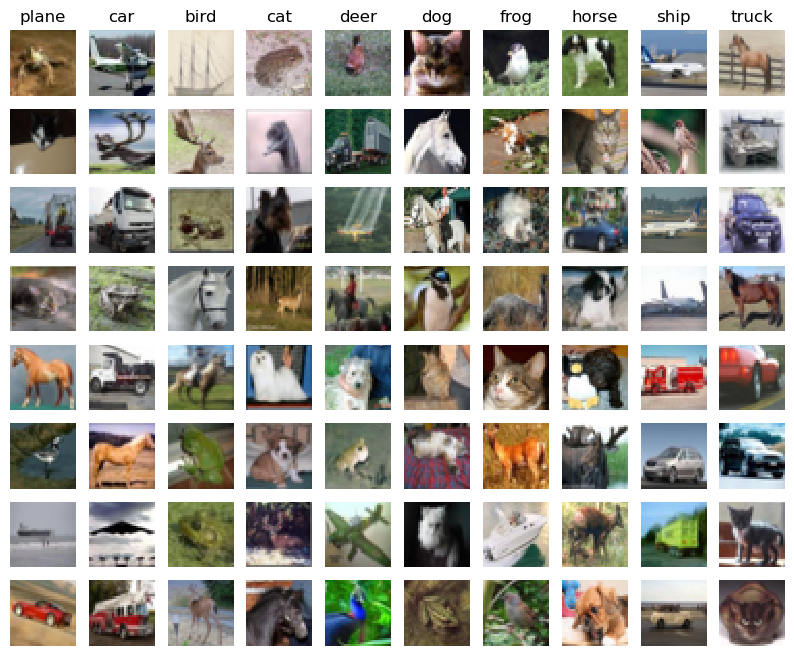

In [16]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$

### START ANSWER HERE ###
No. The results look very mixed. However we see that for each category, there seems to be at least one valid result in the the output data. So the model has very low accuracy but it seems to be working at least for few examples. This seems to be an issue of overfitting to the training data.
### END ANSWER HERE ###


## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels.

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [17]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 170)
(49000, 169)


In [26]:
from xcs231n.classifiers.fc_net import TwoLayerNet
from xcs231n.solver import Solver

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

data = {
    'X_train': X_train_feats,
    'y_train': y_train,
    'X_val': X_val_feats,
    'y_val': y_val,
    'X_test': X_test_feats,
    'y_test': y_test,
}

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# ### START CODE HERE ###
best_val = 0
learning_rates = [2e-3, 1e-3]
hidden_sizes = [700, 750, 800]
for lr in learning_rates:
    for hs in hidden_sizes:
        model = TwoLayerNet(input_dim, hs, num_classes)
        solver = Solver(model, data,
                        num_epochs=10, batch_size=100,
                        update_rule='sgd',
                        optim_config={'learning_rate': lr,},
                        verbose=False)
        solver.train()
        val_acc = solver.val_acc_history[-1]
        if val_acc > best_val:
            best_val = val_acc
            best_net = model
            print(f"New best model found with lr={lr}, hidden_size={hs}, val_acc={val_acc}")
# ### END CODE HERE ###

New best model found with lr=0.002, hidden_size=700, val_acc=0.283
New best model found with lr=0.002, hidden_size=750, val_acc=0.291
New best model found with lr=0.001, hidden_size=750, val_acc=0.311
New best model found with lr=0.001, hidden_size=800, val_acc=0.331


In [27]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 58% accuracy. It is also possible to get >60% accuracy
# with careful tuning.

y_test_pred = np.argmax(best_net.loss(data['X_test']), axis=1)
test_acc = (y_test_pred == data['y_test']).mean()
print(test_acc)

0.332


In [28]:
# Save best model
best_net.save("best_two_layer_net_features.npy")

best_two_layer_net_features.npy saved.


In [29]:
for k, v in best_net.params.items():
  print(k, v.shape)
print(X_train_feats.shape)
print(best_softmax.W.shape)

W1 (169, 800)
b1 (800,)
W2 (800, 10)
b2 (10,)
(49000, 169)
(170, 10)


# Submission

**You will need to submit the answers from this notebook on Gradescope.**